## 2. Relationship between continous and fragmented replays

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions

[2024-08-01 11:35:05,531][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-08-01 11:35:05,574][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
outputFolder='/cumulus/shijie/recording_pilot/eliot/FragmentedReplay/'

In [5]:
nwb_copy_file_name = "eliot20221022_.nwb"

In [6]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(
    nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221022_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221022_ 2         02_Seq2Session pos 1 valid ti
eliot20221022_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221022_ 4         04_Seq2Session pos 3 valid ti
eliot20221022_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221022_ 6         06_Seq2Session pos 5 valid ti
eliot20221022_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221022_ 8         08_Seq2Session pos 7 valid ti
eliot20221022_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221022_ 10        10_Seq2Session pos 9 valid ti
eliot20221022_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



In [7]:
epoch_num = 3
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]
print(session_name)
print(pos_name)

08_Seq2Session4
pos 7 valid times


In [8]:
ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

### 1. >20 ms long fragment interval onset triggered continuous or fragmented

In [9]:
DELTA_T = 1         #1/2 length of the triggered time length
RESOLUTION = 0.005  # time bin size in seconds for binning spikes

In [10]:
from spyglass.shijiegu.fragmented import (concatenate_by_type,
fragmented_triggered)

In [11]:
# put all cont intvl into one array

intvl_cont_all = concatenate_by_type(ripple_times, cont = True)
intvl_frag_all = concatenate_by_type(ripple_times, cont = False)

In [18]:
cont_onset_all, cont_all = fragmented_triggered(ripple_times,
                                                DELTA_T, RESOLUTION, cont = True)
frag_onset_all, frag_all = fragmented_triggered(ripple_times,
                                                DELTA_T, RESOLUTION, cont = False)

# the first output is onset
# the second is the whole duration
number_of_cont = len(cont_all)
#cont_all = np.concatenate(cont_all)
number_of_frag = len(frag_all)
#frag_all = np.concatenate(frag_all)

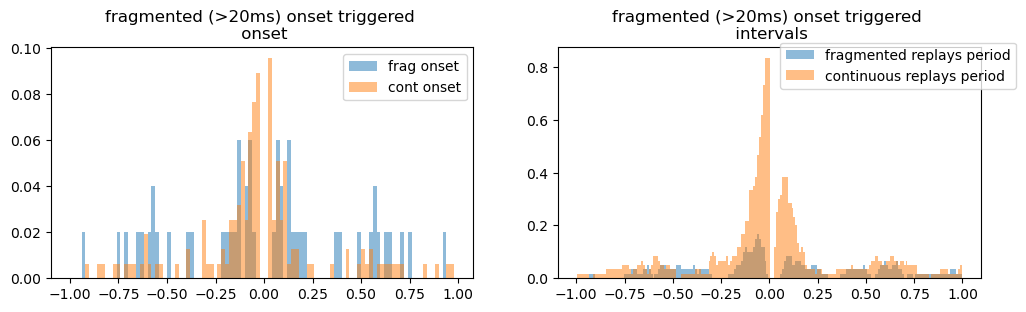

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (12,3))

RESOLUTION = 0.02
axes[0].hist(frag_onset_all,np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T,alpha = 0.5,
        weights = np.ones(number_of_frag)/(number_of_frag),label = 'frag onset')
axes[0].hist(cont_onset_all,np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T,alpha = 0.5,
        weights = np.ones(number_of_cont)/(number_of_cont),label = 'cont onset')

axes[0].set_title('fragmented (>20ms) onset triggered \n onset',fontsize = 12)
axes[0].legend()

RESOLUTION = 0.01


data = []
for i in range(len(frag_all)):
    data1,axis = np.histogram(frag_all[i],np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T)
    data.append(data1)
data = np.array(data)
data = (np.sum(data>0, axis = 0))/60
axes[1].bar(axis[1:],data,alpha = 0.5,width = axis[1]-axis[0],label = 'fragmented replays period')

data = []
for i in range(len(cont_all)):
    data1,axis = np.histogram(cont_all[i],np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T)
    data.append(data1)
data = np.array(data)
data = (np.sum(data>0, axis = 0))/60
axes[1].bar(axis[1:],data,alpha = 0.5,width = axis[1]-axis[0],label = 'continuous replays period')


axes[1].set_title('fragmented (>20ms) onset triggered \n intervals',fontsize = 12)
axes[1].legend(bbox_to_anchor=(1.1, 1.05))

### 2. Fragmented Triggered Continuous Onset AND Content

In [56]:
from spyglass.shijiegu.fragmented import fragmented_triggered_replay

In [82]:
DELTA_T = 1
replay_all = fragmented_triggered_replay(ripple_times, DELTA_T, RESOLUTION)

In [83]:
multiple = []
for r_ind in range(replay_all.shape[0]):
    my_array = replay_all[r_ind]
    not_nan_ind = ~np.isnan(my_array)
    if sum(not_nan_ind) > 0:
        multiple.append(len(np.unique(my_array[not_nan_ind])) > 1)
pct = np.sum(multiple)/len(multiple)
print(f'{round(pct * 100,1)} percentage of ripples that are within {DELTA_T*2} second of a fragmented ripple onset have multiple events ')

25.9 percentage of ripples that are within 2 second of a fragmented ripple onset have multiple events 


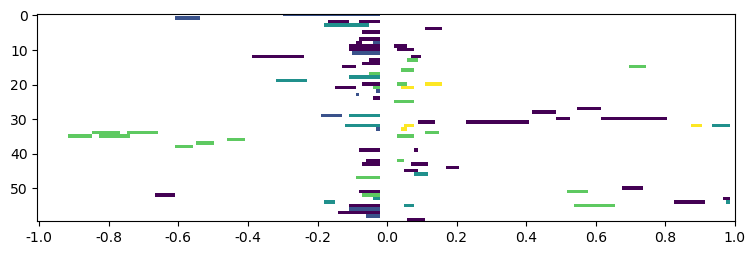

In [84]:
fig, axes = plt.subplots(1, 1, figsize = (9,3))
axes.imshow(replay_all)
extent = [-DELTA_T, DELTA_T, 0, replay_all.shape[0]]
axes.set_xticks(np.linspace(0,replay_all.shape[1],11));
axes.set_xticklabels(np.round(np.linspace(-DELTA_T, DELTA_T, 11),1));

In [85]:
replay_all_random = fragmented_triggered_replay(ripple_times,
                                         DELTA_T,
                                         RESOLUTION, random = True)

In [86]:
multiple = []
for r_ind in range(replay_all_random.shape[0]):
    my_array = replay_all_random[r_ind]
    not_nan_ind = ~np.isnan(my_array)
    if sum(not_nan_ind) > 0:
        multiple.append(len(np.unique(my_array[not_nan_ind])) > 1)
pct = np.sum(multiple)/len(multiple)
print(f'(RANDOM SHIFTED) {round(pct * 100,1)} percentage of ripples that are within {DELTA_T*2} second of a fragmented ripple onset have multiple events ')

(RANDOM SHIFTED) 31.5 percentage of ripples that are within 2 second of a fragmented ripple onset have multiple events 
